In [3]:
import numpy as np
def relu_function(x):
    return np.maximum(0,x)

x = np.array([-1,1,2])
relu_function(x)

array([0, 1, 2])

Populating the interactive namespace from numpy and matplotlib


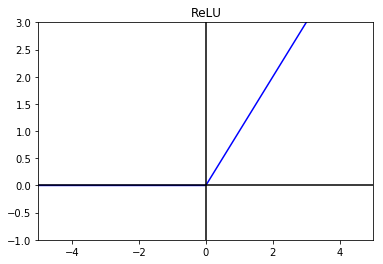

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, relu_function(z), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("ReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
x = np.array([-1,1,2])
leaky_relu(x)

array([-0.01,  1.  ,  2.  ])

Populating the interactive namespace from numpy and matplotlib


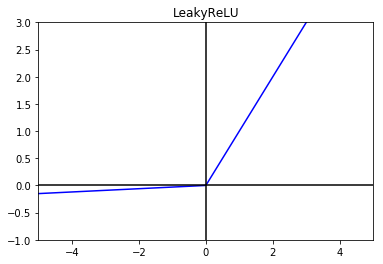

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, leaky_relu(z, 0.03), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("LeakyReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

## 使用GAN 產生手寫辨識數據

In [7]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np

C:\ProgramData\Anaconda3_2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def build_discriminator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [10]:
?Adam

In [11]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [12]:
latent_dim = 100
def build_generator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [13]:
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
__________

In [14]:
z = Input(shape=(latent_dim,))
img = generator(z)

In [15]:
discriminator.trainable = False

In [16]:
validity = discriminator(img)

In [17]:
validity 

<tf.Tensor 'model_2/sequential_2/dense_6/Sigmoid:0' shape=(?, 1) dtype=float32>

In [19]:
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [20]:
import os 
os.mkdir('images')

In [21]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # 正规化图片尺度至0  -  1的范围
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [ ]:
batch_size=32
sample_interval=200
epochs = 5000

(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):


    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)


    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch % sample_interval == 0:
        sample_images(epoch)

## DCGAN

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

### 讀取圖片數據

In [24]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator

### 建立生成器

In [25]:
def build_generator():

    model = Sequential()

    model.add(Dense(units=4 * 4 * 512,
                        input_shape=(1, 1, 100)))
    model.add(Reshape(target_shape=(4, 4, 512)))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=None)

    return model

### 建立鑑別器

In [26]:
def build_discriminator():

    model = Sequential()
    
    image_shape = (64, 64, 3)
    model.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             input_shape=(image_shape)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return model

### 圖片取樣

In [27]:
def sample_images(generated_images, epoch):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(generated_images.shape[0]):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'images/generatedSamples_epoch' + str(
        epoch + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()

### 建構生成器

In [28]:
# 建立生成器
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

In [29]:
## 建立鉴别器
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
__________

In [30]:
gan = Sequential()

discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

optimizer = Adam(lr=0.00015, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)

### 讀取明星圖片

In [45]:
dataset_path = 'idols/'
batch_size   =  64
image_shape  = (64, 64, 3)

dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

Found 211 images belonging to 1 classes.


In [46]:
number_of_batches  = int(dataset_generator.samples / batch_size)
adversarial_loss   = np.empty(shape=1)
discriminator_loss = np.empty(shape=1)
epochs = 250

In [48]:
import os
os.mkdir('models')

Epoch 1 / 250:
 generator loss 14.630633354187012 | discriminator loss 2.609739303588867 
 generator loss 14.563213348388672 | discriminator loss 2.6454224586486816 
 generator loss 14.454696655273438 | discriminator loss 2.2207224369049072 
Epoch 2 / 250:
 generator loss 14.557138442993164 | discriminator loss 2.1075079441070557 
 generator loss 14.509161949157715 | discriminator loss 1.8381092548370361 
 generator loss 14.544391632080078 | discriminator loss 2.0413002967834473 
Epoch 3 / 250:
 generator loss 14.397119522094727 | discriminator loss 1.8946653604507446 
 generator loss 14.528995513916016 | discriminator loss 2.2200517654418945 
 generator loss 14.558133125305176 | discriminator loss 2.3892130851745605 
Epoch 4 / 250:
 generator loss 14.543070793151855 | discriminator loss 2.8663811683654785 
 generator loss 14.569609642028809 | discriminator loss 2.0380301475524902 
 generator loss 14.294775009155273 | discriminator loss 1.8789429664611816 
Epoch 5 / 250:
 generator los

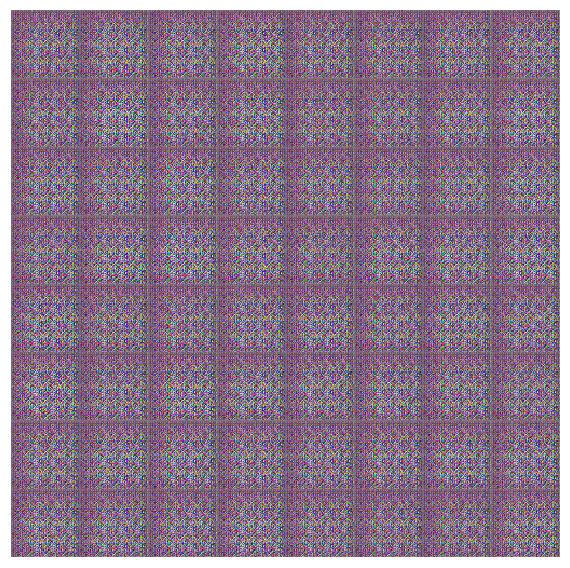

Epoch 6 / 250:
 generator loss 14.61259937286377 | discriminator loss 1.740867018699646 
 generator loss 14.318946838378906 | discriminator loss 1.700275182723999 


In [ ]:
for epoch in range(epochs):
    print("Epoch {} / {}:".format(epoch+1, epochs))

    for batch_number in range(number_of_batches):
        # 取得一批图片数据
        real_images = dataset_generator.next()
        # 将图片标准化至-1到1
        real_images = real_images / 127.5 - 1.

        # 每批大小不同，需每次计算该批数据量
        current_batch_size = real_images.shape[0]

        # 产生噪音
        noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, 100))

        # 使用生成器生成图片
        generated_images = generator.predict(noise)

        # 增加噪音扰乱鉴别器
        real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
        fake_y = np.random.random_sample(current_batch_size) * 0.2

        # 训练鉴别器
        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(real_images, real_y)
        d_loss += discriminator.train_on_batch(generated_images, fake_y)

        discriminator_loss = np.append(discriminator_loss, d_loss)

        # 训练生成器
        discriminator.trainable = False

        noise = np.random.normal(0, 1,size=(current_batch_size * 2,) +(1, 1, 100))

        # 给予反向标签以误导鉴别器
        fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

        g_loss = gan.train_on_batch(noise, fake_y)
        adversarial_loss = np.append(adversarial_loss, g_loss)
    

        # 打印损失
        print(" generator loss {} | discriminator loss {} ".format(g_loss, d_loss))


    # 存储模型与生成图片
    if (epoch + 1) % 5 == 0:
        discriminator.trainable = True
        generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
        discriminator.save('models/discriminator_epoch' +str(epoch) + '.hdf5')
        
        sample_images(generated_images, epoch)